/Users/cag/Dropbox/0_Research/0_githubs/ms_recovery/analysis/5_recovery


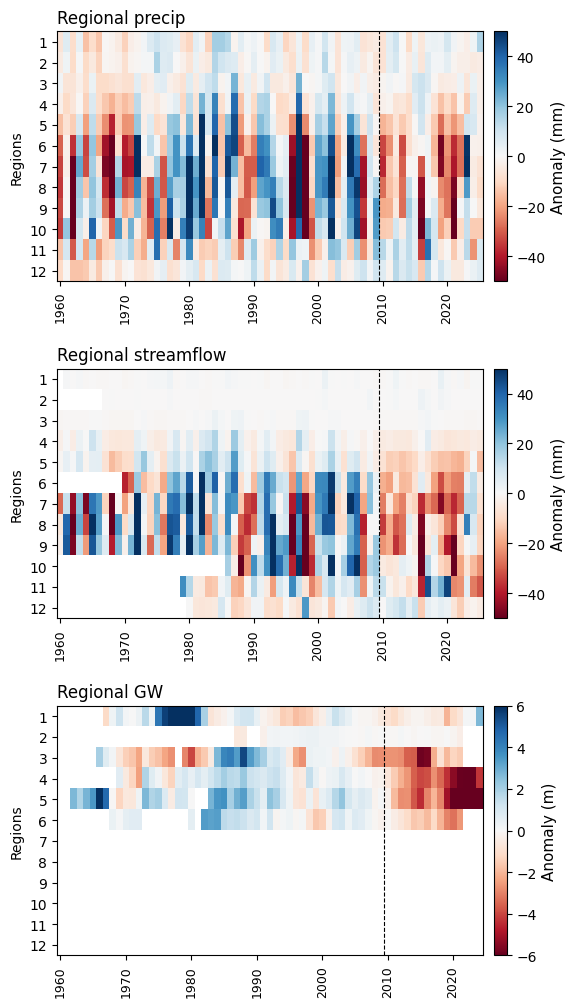

In [30]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm


# run once near the top of the notebook
os.chdir(Path("/Users/cag/Dropbox/0_Research/0_githubs/ms_recovery/analysis/5_recovery"))
print(os.getcwd())
# -------------------- Paths & params --------------------
data_dir = '../../data'
ms_data_dir = f'{data_dir}/ms_data'
camels_dir = f'{data_dir}/camels'

out_figs = 'figs_regional_recovery'
os.makedirs(out_figs, exist_ok=True)

obs_min = 100        # min monthly observations required per well/station overall
n_well_means = 5     # min # wells/stations required per group-year to compute the annual mean

# -------------------- Region mapping (your rule) --------------------
def extract_region(code):
    s = str(code)
    return int(s[:2]) if len(s) == 8 else int(s[0])

def map_regions(columns):
    regions = {}
    for c in columns:
        try:
            regions[c] = extract_region(c)
        except Exception:
            regions[c] = np.nan
    # drop columns that failed mapping
    regions = {k: v for k, v in regions.items() if pd.notna(v)}
    return regions

# -------------------- Load monthly anomalies (GW & PR tied to wells) --------------------
gw_abs_all = pd.read_csv(f'{ms_data_dir}/wells_gw.csv', parse_dates=['date']).set_index('date')
gw_climatology = gw_abs_all.groupby(gw_abs_all.index.month).transform('mean')
# gw_climatology_abs = gw_climatology.abs()
# gw_an_all = 100 * (gw_abs_all - gw_climatology).divide(gw_climatology.replace(0, np.nan))
gw_an_all = gw_abs_all - gw_climatology
gw_m = gw_an_all

# -------------------- Filter wells by GW obs count (overall) --------------------
gw_counts = gw_an_all.notna().sum(axis=0)
keep_wells = gw_counts[gw_counts >= obs_min].index.tolist()
if not keep_wells:
    raise ValueError("No wells meet the obs_min criterion.")


# -------------------- STREAMFLOW (Q): load anomalies, or compute if needed --------------------
q_all = pd.read_csv(f'{camels_dir}/camels_q_mm.csv', parse_dates=['date']).set_index('date')
q_climatology = q_all.groupby(q_all.index.month).transform('mean')
# q_an_all = 100 * (q_all - q_climatology).divide(q_climatology.replace(0, np.nan))
q_an_all = q_all - q_climatology

pr_all_stream = pd.read_csv(f'{camels_dir}/camels_pr_mm.csv', parse_dates=['date']).set_index('date')
pr_climatology_stream = pr_all_stream.groupby(pr_all_stream.index.month).transform('mean')
# pr_an_all = 100 * (pr_all_stream - pr_climatology_stream).divide(pr_climatology_stream.replace(0, np.nan))
pr_an_all = pr_all_stream - pr_climatology_stream

# Filter streamflow stations by obs_min
q_counts = q_an_all.notna().sum(axis=0)
keep_stations = q_counts[q_counts >= obs_min].index.tolist()
if not keep_stations:
    raise ValueError("No streamflow stations meet the obs_min criterion.")
q_m = q_an_all[keep_stations]
pr_m = pr_an_all[keep_stations]

# -------------------- Monthly → Annual (mean over months) --------------------
gw_y = gw_m.resample('YE-DEC').mean()   # annual mean GW anomaly per well (m)
pr_y = pr_m.resample('YE-DEC').mean()   # annual mean PR anomaly per well (mm)
q_y  = q_m.resample('YE-DEC').mean()    # annual mean Q anomaly per station (units of series)

# convert index to year
for df in (gw_y, pr_y, q_y):
    df.index = df.index.year

# -------------------- Region maps per dataset (YOUR RULE) --------------------
gw_regions = map_regions(gw_y.columns)
pr_regions = map_regions(pr_y.columns)
q_regions  = map_regions(q_y.columns)

# restrict dfs to columns that mapped successfully
gw_y = gw_y[list(gw_regions.keys())]
pr_y = pr_y[list(pr_regions.keys())]
q_y  = q_y[list(q_regions.keys())]

# -------------------- Assign region to columns and compute group means with thresholds --------------------
def groupmean_with_min_count(df_yearly, col2region, min_count):
    # MultiIndex columns: (region, id)
    df_yearly.columns = pd.MultiIndex.from_tuples([(col2region[c], c) for c in df_yearly.columns],
                                                  names=['region', 'id'])
    # count #ids with data per (year, region)
    counts = df_yearly.T.groupby(level='region').count().T
    # mean over ids per region
    means  = df_yearly.T.groupby(level='region').mean().T
    # mask where insufficient contributing ids
    means  = means.where(counts >= min_count)
    # sort regions ascending (N→S if codes increase southwards)
    means  = means.reindex(columns=sorted(means.columns))
    return means, counts

gw_grp, gw_cnt = groupmean_with_min_count(gw_y, gw_regions, n_well_means)
pr_grp, pr_cnt = groupmean_with_min_count(pr_y, pr_regions, n_well_means)
q_grp,  q_cnt  = groupmean_with_min_count(q_y,  q_regions,  n_well_means)

# -------------------- Harmonize region set and build matrices --------------------
# -------------------- Use the SAME region set for all three (from PR ∪ Q), apply to GW too --------------------
regions_all = sorted(set(pr_grp.columns).union(set(q_grp.columns)))
# If GW has fewer/more, reindex to the common set so y-axis aligns
gw_grp = gw_grp.reindex(columns=regions_all)
pr_grp = pr_grp.reindex(columns=regions_all)
q_grp  = q_grp.reindex(columns=regions_all)

region_labels = [str(r) for r in regions_all]

def to_matrix(df_grp, region_order):
    if df_grp.empty:
        return np.empty((len(region_order), 0))
    df_ord = df_grp.reindex(columns=region_order)
    return df_ord.values.T, df_ord.index.values  # matrix (n_regions, n_years), years

gw_mat, years_gw = to_matrix(gw_grp, regions_all)
pr_mat, years_pr = to_matrix(pr_grp, regions_all)
q_mat,  years_q  = to_matrix(q_grp,  regions_all)


def decadal_xticks(years):
    if years is None or len(years) == 0:
        return []
    years = np.unique(np.sort(years))
    start = (years.min() // 10) * 10
    end = (years.max() // 10) * 10
    decades = np.arange(start, end + 10, 10)
    decades = decades[(decades >= years.min()) & (decades <= years.max())]
    if decades.size == 0:
        return years
    return decades

# -------------------- Color scaling --------------------
# Shared norm for PR & Q (percent)
pq_norm = TwoSlopeNorm(vmin=-50, vcenter=0.0, vmax=50)
# Independent norm for GW (percent)
gw_norm = TwoSlopeNorm(vmin=-6, vcenter=0.0, vmax=6)


# -------------------- Plot (3×1, colorbars at right, larger) --------------------
fig, (ax_pr, ax_q, ax_gw) = plt.subplots(3, 1, figsize=(6,12), constrained_layout=False, sharex=False, sharey=True)
fig.subplots_adjust(hspace=0.35)

cmap='RdBu'
# Precip (%)
if pr_mat.size:
    im_pr = ax_pr.imshow(
        pr_mat, aspect='auto', interpolation='nearest', cmap=cmap, norm=pq_norm,
        extent=[years_pr.min() - 0.5 if len(years_pr) else -0.5,
                years_pr.max() + 0.5 if len(years_pr) else 0.5,
                len(region_labels) - 0.5, -0.5]
    )
    ax_pr.set_title('Regional precip', loc='left')
    ax_pr.set_ylabel('Regions')
    ax_pr.set_yticks(np.arange(len(region_labels)))
    ax_pr.set_yticklabels(region_labels, fontsize=10)
    xt = decadal_xticks(years_pr); ax_pr.set_xticks(xt); ax_pr.set_xticklabels(xt, rotation=90, ha='center', fontsize=9)
    cb_pr = fig.colorbar(im_pr, ax=ax_pr, orientation='vertical', pad=0.025, fraction=0.06)
    cb_pr.set_label('Anomaly (mm)', fontsize=11)
    cb_pr.ax.tick_params(labelsize=10)
    ax_pr.axvline(2009.5, color='black', linestyle='--', linewidth=.8)
else:
    ax_pr.text(0.5, 0.5, 'No PR data', ha='center', va='center'); ax_pr.axis('off')

# Streamflow (%)
if q_mat.size:
    im_q = ax_q.imshow(
        q_mat, aspect='auto', interpolation='nearest', cmap=cmap, norm=pq_norm,
        extent=[years_q.min() - 0.5 if len(years_q) else -0.5,
                years_q.max() + 0.5 if len(years_q) else 0.5,
                len(region_labels) - 0.5, -0.5]
    )
    ax_q.set_title('Regional streamflow', loc='left')
    ax_q.set_ylabel('Regions')
    ax_q.set_yticks(np.arange(len(region_labels)))
    ax_q.set_yticklabels(region_labels, fontsize=10)
    xt = decadal_xticks(years_q); ax_q.set_xticks(xt); ax_q.set_xticklabels(xt, rotation=90, ha='center', fontsize=9)
    cb_q = fig.colorbar(im_q, ax=ax_q, orientation='vertical', pad=0.025, fraction=0.06)
    cb_q.set_label('Anomaly (mm)', fontsize=11)
    cb_q.ax.tick_params(labelsize=10)
    ax_q.axvline(2009.5, color='black', linestyle='--', linewidth=.8)
else:
    ax_q.text(0.5, 0.5, 'No Q data', ha='center', va='center'); ax_q.axis('off')
    ax_q.axvline(2009.5, color='black', linestyle='--', linewidth=.8)

# Groundwater (%)
if gw_mat.size:
    im_gw = ax_gw.imshow(
        gw_mat, aspect='auto', interpolation='nearest', cmap=cmap, norm=gw_norm,
        extent=[years_gw.min() - 0.5 if len(years_gw) else -0.5,
                years_gw.max() + 0.5 if len(years_gw) else 0.5,
                len(region_labels) - 0.5, -0.5]
    )
    ax_gw.set_title('Regional GW', loc='left')
    ax_gw.set_ylabel('Regions')
    ax_gw.set_yticks(np.arange(len(region_labels)))
    ax_gw.set_yticklabels(region_labels, fontsize=10)
    xt = decadal_xticks(years_gw); ax_gw.set_xticks(xt); ax_gw.set_xticklabels(xt, rotation=90, ha='center', fontsize=9)
    cb_gw = fig.colorbar(im_gw, ax=ax_gw, orientation='vertical', pad=0.025, fraction=0.06)
    cb_gw.set_label('Anomaly (m)', fontsize=11)
    cb_gw.ax.tick_params(labelsize=10)
    ax_gw.axvline(2009.5, color='black', linestyle='--', linewidth=.8)
else:
    ax_gw.text(0.5, 0.5, 'No GW data', ha='center', va='center'); ax_gw.axis('off')
